# Neural Network with Pytorch Lightning

As stated in the assignment prompt, my goal was not to create the perfect model for fraud detection. Rather, my objective was to demonstrate my skills in data science and software engineering.

To that end, I developed this neural network using the PyTorch Lightning framework, even though machine learning models are often better suited and less resource-intensive for addressing heavily imbalanced problems like this.

I greatly appreciate PyTorch Lightning, as it allows for the perfect structuring of PyTorch code into various modules and facilitates integration with services like logging and callbacks.

## Imports

In [1]:
import os
import torch
import numpy as np
import pandas as pd
from torch.nn import BCEWithLogitsLoss
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight


from fraud.nn.train import TrainerManager
from fraud.nn.model import LightningFraudClassifier
from fraud.nn.classifier import FraudDetectionModel
from fraud.nn.data import DataModule

from fraud.preprocess import preprocess_with_labelencoder
from fraud.nn.metrics import get_metrics
from fraud.plots import PerformancePlotter
from fraud.constants import (
    COL_BANK_MONTHS_COUNT,
    COL_PREV_ADDRESS_MONTHS_COUNT,
    COL_VELOCITY_4W,
    COL_DF_LABEL_FRAUD
)



## Load the data

In [2]:
FILENAME = "./data/Base.csv"
df = pd.read_csv(FILENAME)
df.shape

(1000000, 32)

## Remove the features that bring bias

From the Exploratory Data Analysis notebook, we identified features that do not contribute to improving the model, so we decided to remove these columns.

In [3]:
df = df.drop(columns=[
    COL_BANK_MONTHS_COUNT, 
    COL_PREV_ADDRESS_MONTHS_COUNT,
    COL_VELOCITY_4W
    ]
)

## Remove the empty rows

As we observed during the EDA, there is very little missing data. Although XGBoost can handle missing values, it is simpler to remove them as a starting point.

In [4]:
cols_missing = [
    'current_address_months_count',
    'session_length_in_minutes',
    'device_distinct_emails_8w',
    'intended_balcon_amount'
]

df[cols_missing] = df[cols_missing].replace(-1, np.nan)

df= df.dropna()
df.shape

(993607, 29)

## Preprocessing

In [5]:
df_preprocessed, label_encoder, sclarer = preprocess_with_labelencoder(
    df=df, 
    col_label=COL_DF_LABEL_FRAUD
)

## Split the dataframe in train, val, test

In [6]:
test_size = 0.30
val_size = 0.5

train_df, test_df = train_test_split(
    df_preprocessed,
    test_size=test_size,
    random_state=42,
    shuffle=True,
    stratify=df_preprocessed[COL_DF_LABEL_FRAUD],
)

# Split to create a train and validation dataframe
test_df, val_df = train_test_split(
    test_df,
    test_size=val_size,
    shuffle=True,
    random_state=42,
    stratify=test_df[COL_DF_LABEL_FRAUD],
)

## Compute the class weights

In [7]:
# Compute the class weights
class_weights = compute_class_weight(
        class_weight="balanced",
        classes=train_df[COL_DF_LABEL_FRAUD].unique(),
        y=train_df[COL_DF_LABEL_FRAUD],
    )
tensor_class_weights = torch.tensor(data=class_weights, dtype=torch.float32)

## Create the Lightning Datamodule

In [8]:
pl_datamodule = DataModule(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df, 
    batch_size=128,
    # num_workers=0,
    # prefetch_factor=None,
    # persistent_workers=False
)

num_classes = tensor_class_weights.shape[0]
print(tensor_class_weights)

tensor([ 0.5056, 45.1874])


## Create the Lightning Module

In [9]:
model = FraudDetectionModel(df.shape[1]-1)
metrics= get_metrics(num_classes=num_classes)
criterion = BCEWithLogitsLoss(pos_weight=tensor_class_weights[1])

pl_model = LightningFraudClassifier(
    num_classes=num_classes,
    model=model,
    metrics=metrics,
    criterion=criterion,
)

## Create the Trainer

In [10]:
run_datadir = "./model_trained"

trainer = TrainerManager(
    pl_datamodule=pl_datamodule,
    pl_model=pl_model,
    run_datadir=run_datadir
)

## Train the model

In [11]:
model_trained, _ = trainer.train(epochs=22, use_gpu=False)

Seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/maicolrodrigues/Documents/Test/FIA/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/maicolrodrigues/Documents/Test/FIA/.venv/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/maicolrodrigues/Documents/Test/FIA/model_trained/checkpoints exists and is not empty.

  | Name          | Type                | Params | Mode 
--------------------------------------------------------------
0 | metrics       | MetricCollection    | 0      | train
1 | model         | FraudDetectionModel | 12.4 K | train
2 | critirion     | BCEWithLogitsLoss   | 0      | train
3 | train_metrics | MetricCollection    | 0      | train
4 | val_metrics   | MetricCollection    | 0      | train
5 | test_metrics  | 

Epoch 0:   1%|          | 47/5434 [00:02<05:01, 17.84it/s, v_num=ed1c] 

/Users/maicolrodrigues/Documents/Test/FIA/.venv/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 0: 100%|██████████| 5434/5434 [01:47<00:00, 50.41it/s, v_num=ed1c] 

Metric val_loss improved. New best score: 0.645


Epoch 1: 100%|██████████| 5434/5434 [04:20<00:00, 20.88it/s, v_num=ed1c]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.630


Epoch 2: 100%|██████████| 5434/5434 [06:58<00:00, 12.99it/s, v_num=ed1c]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.626


Epoch 3: 100%|██████████| 5434/5434 [09:37<00:00,  9.42it/s, v_num=ed1c]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.623


Epoch 5: 100%|██████████| 5434/5434 [14:50<00:00,  6.10it/s, v_num=ed1c]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.621


Epoch 6: 100%|██████████| 5434/5434 [17:41<00:00,  5.12it/s, v_num=ed1c]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.619


Epoch 7: 100%|██████████| 5434/5434 [20:25<00:00,  4.44it/s, v_num=ed1c]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.614


Epoch 8: 100%|██████████| 5434/5434 [23:11<00:00,  3.90it/s, v_num=ed1c]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.612


Epoch 9: 100%|██████████| 5434/5434 [26:04<00:00,  3.47it/s, v_num=ed1c]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.611


Epoch 10: 100%|██████████| 5434/5434 [28:51<00:00,  3.14it/s, v_num=ed1c]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.610


Epoch 11: 100%|██████████| 5434/5434 [31:38<00:00,  2.86it/s, v_num=ed1c]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.609


Epoch 12: 100%|██████████| 5434/5434 [34:23<00:00,  2.63it/s, v_num=ed1c]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.606


Epoch 14: 100%|██████████| 5434/5434 [39:37<00:00,  2.29it/s, v_num=ed1c]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.605


Epoch 15: 100%|██████████| 5434/5434 [42:11<00:00,  2.15it/s, v_num=ed1c]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.604


Epoch 17: 100%|██████████| 5434/5434 [47:55<00:00,  1.89it/s, v_num=ed1c]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.604


Epoch 20: 100%|██████████| 5434/5434 [56:31<00:00,  1.60it/s, v_num=ed1c]

Monitored metric val_loss did not improve in the last 3 records. Best score: 0.604. Signaling Trainer to stop.


Epoch 20: 100%|██████████| 5434/5434 [56:31<00:00,  1.60it/s, v_num=ed1c]


## Test the model

In [12]:
test_metrics = trainer.test()

Restoring states from the checkpoint path at /Users/maicolrodrigues/Documents/Test/FIA/model_trained/checkpoints/epoch=17-val_loss=0.60.ckpt
Loaded model weights from the checkpoint at /Users/maicolrodrigues/Documents/Test/FIA/model_trained/checkpoints/epoch=17-val_loss=0.60.ckpt


Testing DataLoader 0:   1%|          | 12/1165 [00:00<00:33, 34.36it/s]

/Users/maicolrodrigues/Documents/Test/FIA/.venv/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Testing DataLoader 0: 100%|██████████| 1165/1165 [00:05<00:00, 195.96it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   test_accuracy_macro     0.011064069345593452
       test_auroc           0.37718814611434937
 test_f1_score_weighted    0.021717699244618416
        test_loss           0.5876250267028809
 test_precision_weighted   0.011064069345593452
  test_recall_weighted      0.7543762922286987
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Load the trained model stored locally in the best checkpoints

Let's compare with the same plotter used for the Xgboost model. To be able to do that we need first to load the statedict from the best checkpoints

In [13]:
from fraud.nn.model import FraudDetectionModel
from pathlib import Path

path_checkpoints_folder = Path(run_datadir, "checkpoints")
listfile_in_checkpoint = os.listdir(path_checkpoints_folder)
checkpoint_file = Path(path_checkpoints_folder, listfile_in_checkpoint[0])
print(checkpoint_file)

checkpoints = torch.load(checkpoint_file)

model_trained/checkpoints/epoch=17-val_loss=0.60.ckpt


/var/folders/8f/_56c51kx1ld_nnt9hkkz02l80000gn/T/ipykernel_2262/1419093659.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoints = torch.load(checkpoint_file)


In [14]:
# Get the input dim of the model from the checkpoints
imputs_dim = checkpoints.get("state_dict").get("model.fc1.weight").shape[1]

state_dict = checkpoints["state_dict"]
new_state_dict = {
    k.replace("model.", ""): v
    for k, v in state_dict.items()
    if "critirion.pos_weight" not in k
}

In [15]:
# Load the model from the checkpoints
model_loaded = FraudDetectionModel(imputs_dim)
model_loaded.load_state_dict(new_state_dict)

# Load the test dataloader from the DataModule
test_dataloader = pl_datamodule.test_dataloader()

y_true = []
y_probs = []

for batch in test_dataloader:
    inputs, targets = batch

    with torch.no_grad():  # Disable gradient computation
        outputs = model_loaded(inputs)
        probabilities = torch.sigmoid(outputs).cpu().numpy()
        positive_probs = probabilities.squeeze()  # Get probabilities for the positive class

    y_true.extend(targets.cpu().numpy())  
    y_probs.extend(positive_probs)

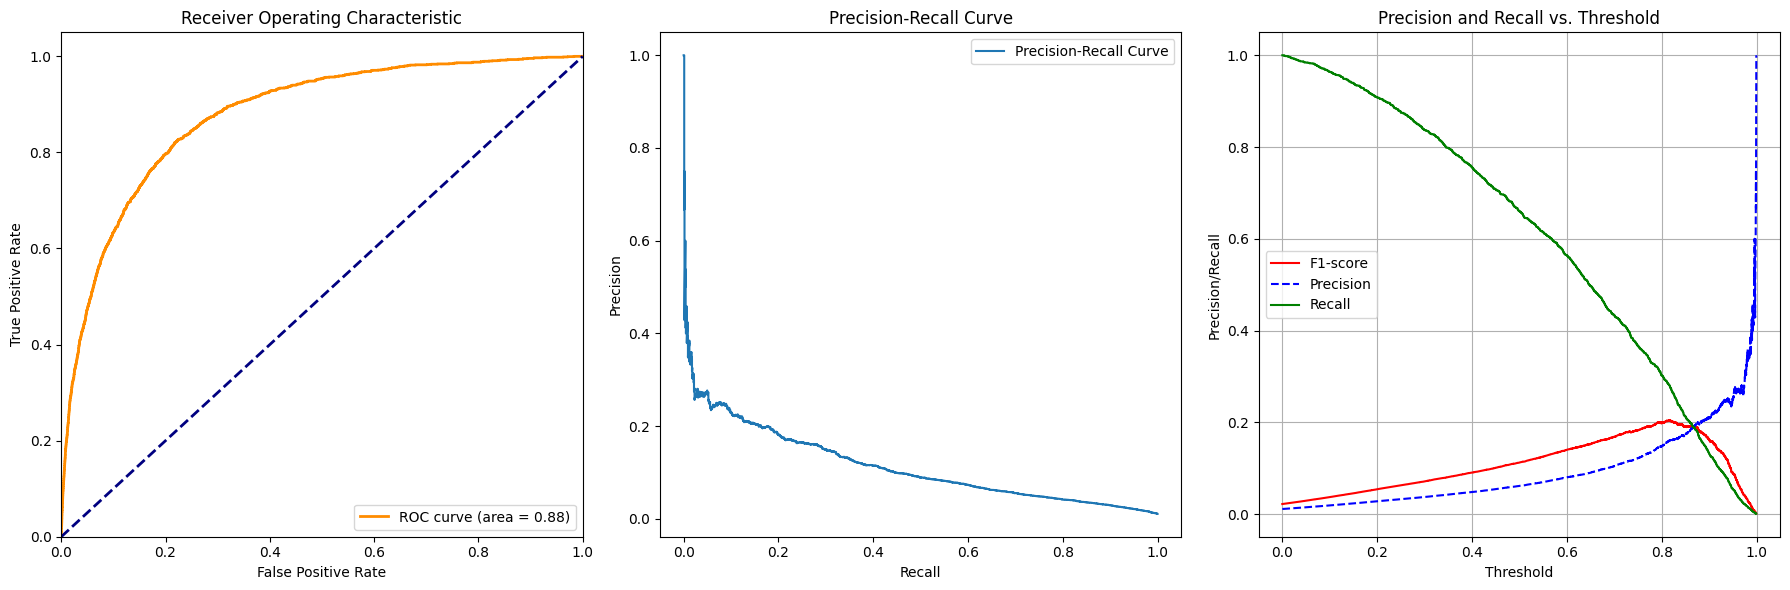

In [16]:
plotter = PerformancePlotter()
plotter.plot_metrics(y_true, y_probs) 